In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rounding = "round"):
    in_feature = 1024
    out_feature = 1024
    bias = True

    input = (torch.rand(256, in_feature) - 0.5).to(device)

    fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
    fc_o = fc(input)
    
    ufc_err_min_list = []
    ufc_err_max_list = []
    ufc_err_mean_list = []
    ufc_err_std_list = []

    ffc_err_min_list = []
    ffc_err_max_list = []
    ffc_err_mean_list = []
    ffc_err_std_list = []
    
    x_label = []
    
    for bitwidth in range(6, 13): 
        cycle = 2**(bitwidth-1)

        ufc = HUBLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, cycle=cycle, rounding=rounding).to(device)
        ufc_o = ufc(input)

        ffc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, rounding=rounding).to(device)
        ffc_o = ffc(input)

        ufc_err = (ufc_o - fc_o)
        ffc_err = (ffc_o - fc_o)
        
        ufc_err_min_list.append(ufc_err.min().item())
        ufc_err_max_list.append(ufc_err.max().item())
        ufc_err_mean_list.append(ufc_err.mean().item())
        ufc_err_std_list.append(ufc_err.std().item())
        
        ffc_err_min_list.append(ffc_err.min().item())
        ffc_err_max_list.append(ffc_err.max().item())
        ffc_err_mean_list.append(ffc_err.mean().item())
        ffc_err_std_list.append(ffc_err.std().item())
        
        x_label.append(2**(bitwidth-1))
        
    return ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ffc_err_min_list, ffc_err_max_list, ffc_err_mean_list, ffc_err_std_list, x_label


In [5]:
rounding = "round"
ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ffc_err_min_list, ffc_err_max_list, ffc_err_mean_list, ffc_err_std_list, x_label = test(rounding)
print(ufc_err_min_list)
print(ufc_err_max_list)
print(ufc_err_mean_list)
print(ufc_err_std_list)

print(ffc_err_min_list)
print(ffc_err_max_list)
print(ffc_err_mean_list)
print(ffc_err_std_list)

print(x_label)

[-0.07491344213485718, -0.03827792406082153, -0.01913774013519287, -0.009229123592376709, -0.00495457649230957, -0.0026011765003204346, -0.0012622177600860596]
[0.07377147674560547, 0.04067647457122803, 0.018600553274154663, 0.009750455617904663, 0.005476057529449463, 0.00254058837890625, 0.001405179500579834]
[1.3032549759373069e-06, -9.223491360899061e-06, 6.193622994032921e-06, 2.3419047465722542e-06, 4.677667675423436e-08, -2.62053049482347e-07, 2.9708871807088144e-07]
[0.016595084220170975, 0.00848046038299799, 0.004310774151235819, 0.002199579030275345, 0.0011196660343557596, 0.0005709397955797613, 0.00029454860487021506]
[-0.01707351580262184, -0.008212536573410034, -0.004229694604873657, -0.0020357929170131683, -0.0010727643966674805, -0.0006305165588855743, -0.00022584199905395508]
[0.017288774251937866, 0.008399397134780884, 0.0043724775314331055, 0.0022996068000793457, 0.0011163093149662018, 0.0006096288561820984, 0.00020578503608703613]
[5.417616648628609e-06, -2.0486634184

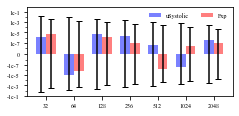

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family':'Times New Roman', 'size': 6}

matplotlib.rc('font', **font)

my_dpi = 300
fig_h = 1.6
fig_w = 3.3115

# construct some data like what you have:
x = np.array([i for i in range(len(ufc_err_mean_list))])
means1 = np.array(ufc_err_mean_list)
stds1 = np.array(ufc_err_std_list)
mins1 = np.array(ufc_err_min_list)
maxs1 = np.array(ufc_err_max_list)
means2 = np.array(ffc_err_mean_list)
stds2 = np.array(ffc_err_std_list)
mins2 = np.array(ffc_err_min_list)
maxs2 = np.array(ffc_err_max_list)
x_label = np.array(x_label)

width = 0.35
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.bar(x-width/2, means1, width, yerr=stds1, align='center', alpha=1, capsize=3, color="#7A81FF", label="uSystolic")
ax.bar(x+width/2, means2, width, yerr=stds2, align='center', alpha=1, capsize=3, color="#FF7F7F", label="Fxp")
ax.set_xticks(x)
ax.set_xticklabels(x_label)

ax.set_yscale('symlog', linthresh=10**(-8))
ax.set_ylim(-0.1, 0.99)
ax.set_yticks([-10**(-1), -10**(-3), -10**(-5), -10**(-7), 0, 10**(-7), 10**(-5), 10**(-3), 10**(-1)])
# ax.set_yticklabels([-10**(-2), -10**(-4), -10**(-6), -10**(-8), 0, 10**(-8), 10**(-6), 10**(-4), 10**(-2)])
ax.set_yticklabels(["-1e-1", "-1e-3", "-1e-5", "-1e-7", "0", "1e-7", "1e-5", "1e-3", "1e-1"])
ax.legend(loc="upper right", ncol=2, frameon=False)

fig.tight_layout()
plt.show()
fig.savefig("test_kernel_linear_fxp_hub_compare.pdf", bbox_inches='tight', dpi=my_dpi)
